We can use dimensionality reduction to turn a intractable problem into a tractable one.
<br>In some cases, we may lose info (like jpeg compression) + it makes system more complex, so try to train system with original data first.
<br>In other cases, it can improve performance by e.g. filtering out noise and unnecessary details.
<br>But mostly, it just speeds up training.
<br>It's useful for data viz too.

# Curse of Dimensionality
Our intuition fails when we imagine a high-dim space.

E.g. a random point in a unit square has only 0.4% chance of being located < 0.001 from the border (AKA highly unlikely a random point will be "extreme" along any dim)
<br>But in a 10k-dim unit hypercube, the probability is > 99.9999% (most points in high-dim hypercube are very close to the border)

E.g. 2 random points in a unit square will be, on average, at a distance of around 0.52
<br>In a 3D unit cube, it'll be 0.66
<br>But in a 1M-dim unit hypercube, average distance will be around 408.25
  - counterintuitive: how can 2 points be so far away when they lie in the same unit hypercube
  - there's plenty of space in high dims, so high-dim datasets are at risk of being very sparse (most instances are far away from each other)
    - new instances will also be far away from training instances, which makes predictions unreliable as predictions will be based on much larger extrapolations
    - AKA more risk of overfitting


<br>1 way to solve this would be to increase training set size so that we reach a sufficient density of instances, but number of instances to reach a given density grows exponentially with number of dims.
  - with 100 features (ranging from 0 to 1), need more instances than atoms in observable universe for instances to be within 0.1 of each other on average, assuming they're spread out uniformly across all dims

# Approaches for Dim Reduction
There are specific algos for dim reduction, each follows one of 2 main approaches:

### Projection
In real-world problems, many features are either almost constant or highly correlated, which means all instances lie within a subspace.
<br>One way to reduce dim is to project all instances perpendicularly onto this subspace.

### Manifold Learning
If the subspace twists and turns (e.g. Swiss roll toy dataset), projecting perpendicularly isn't the best approach.
<br>We want to unroll the Swiss roll rather than squash its layers together by projecting.
<br>The Swiss roll is a 2D manifold.
  - 2D manifold = 2D shape that can be bent/twisted in a higher-dim space
  - a d-dim manifold is part of n-dim space that locally resembles a d-dim hyperplane
    - for Swiss roll, d = 2 and n = 3, and it locally resembles a 2D plane but is rolled in a 3rd dim 

Manifold learning algos rely on manifold assumption/hypothesis, that dataset lies close to a lower-dim manifold.
<br>This is often observed empirically.

The degrees of freedom to make a digit are dramatically lower than if you're allowed to generate any image.
  - these constraints squeeze dataset into a lower-dim manifold

Another implicit assumption is that the task is simpler in lower-dim space.
<br>This isn't always true
  - a dataset may be divided by a vertical plane in original 3D space, but may need multiple lines in the unrolled manifold.

# PCA
- Identifies the hyperplane closest to data
- Then projects the data onto it

The axes of new dim must maximize variance.
  - Maximize variance = preserve most info
  - also minimizes distance b/w original dataset and its projection

For each principal component, PCA finds a zero-centered unit vector pointing in PC's direction.
<br>2 opposing unit vectors lie on the same axis, so direction of PC is not stable
i.e. perturbing training set slightly can cause PC to point in opposite direction, or may even rotate/swap a pair of unit vectors (if their variances along these 2 axes are close)

### Singular Value Decomposition
Used by PCA to find PCs.
<br>X is decomposed into matrices U, sigma and V transpose
<br>V contains unit vectors for the PCs, V = |c1 c2 ... cn|

In [3]:
import numpy as np

X = np.array([[np.random.randn() for _ in range(3)] for _ in range(10)])
# PCA assumes data is centered around origin
# Need to remember this if we use other libraries or implement it ourselves
X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)

c1 = Vt[0]
c2 = Vt[1]

c1, c2

(array([ 0.83014213, -0.37333658,  0.41410607]),
 array([0.35320447, 0.92681544, 0.12751369]))

In [5]:
W_2 = Vt[:2].T  # Vt is transposed, transpose again to get untransposed V
# project X to d-dim by multiplying with W
# W contains first d columns of V
X_2d = X_centered @ W_2
X_2d

array([[-0.39446166, -0.79518791],
       [-1.81107908,  0.11901836],
       [ 0.96278187, -0.93273639],
       [ 1.000145  ,  1.21303152],
       [ 1.44556739, -1.05961435],
       [ 2.68746859,  0.02130772],
       [-1.2344662 ,  0.95702841],
       [-2.2462274 , -1.23378723],
       [ 0.27804791,  0.67090003],
       [-0.68777643,  1.04003983]])

### Using Sklearn

In [7]:
from sklearn.decomposition import PCA

# this takes care of centering the data, so we don't need to do that
pca = PCA(n_components=2)
X_2d_sk = pca.fit_transform(X)
X_2d_sk

array([[-0.39446166, -0.79518791],
       [-1.81107908,  0.11901836],
       [ 0.96278187, -0.93273639],
       [ 1.000145  ,  1.21303152],
       [ 1.44556739, -1.05961435],
       [ 2.68746859,  0.02130772],
       [-1.2344662 ,  0.95702841],
       [-2.2462274 , -1.23378723],
       [ 0.27804791,  0.67090003],
       [-0.68777643,  1.04003983]])

In [8]:
# holds W_d transpose
# its rows contain first d columns of V
pca.components_

array([[ 0.83014213, -0.37333658,  0.41410607],
       [ 0.35320447,  0.92681544,  0.12751369]])

### Explained Variance Ratio
Proportion of dataset's variance that lies along each PC

In [10]:
pca.explained_variance_ratio_

array([0.65723379, 0.24368975])

In [12]:
# only 9% variance is left
# so 3rd compo carries little info
1 - sum(pca.explained_variance_ratio_)

np.float64(0.09907645423063749)

### Choosing Number of Dims
Can choose this by considering how much variance we want to preserve

In [14]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml("mnist_784", as_frame=False)

X_tr, y_tr = mnist.data[:60_000], mnist.target[:60_000]
X_ts, y_ts = mnist.data[60_000:], mnist.target[60_000:]

pca = PCA()
pca.fit(X_tr)

cumulative_sum = np.cumsum(pca.explained_variance_ratio_)

# want to preserve 95% variance
d = np.argmax(cumulative_sum >= 0.95) + 1  # add 1 cuz this gives index, which starts from 0
d

np.int64(154)

Or we can tell PCA how much variance we want to preserve

In [15]:
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_tr)
pca.n_components_

np.int64(154)

Another option is to plot explained variance as a function of number of dims

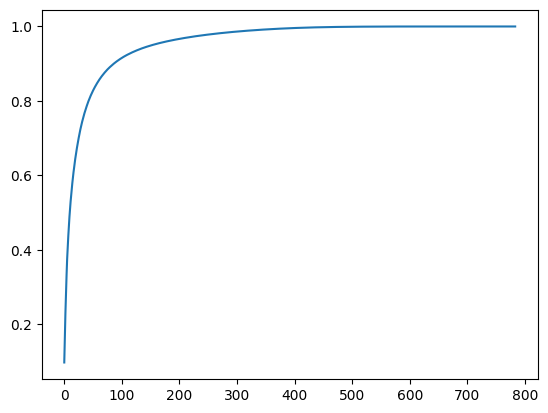

In [16]:
import matplotlib.pyplot as plt

plt.plot(cumulative_sum)
plt.show()

If we're using dim reduction as a preprocessing step, then we can keep "d" as a hyperparameter

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import make_pipeline

clf = make_pipeline(PCA(random_state=42),
                    RandomForestClassifier(random_state=42))
param_distrib = {
    "pca__n_components": np.arange(10,80),
    "randomforestclassifier__n_estimators": np.arange(50,500)
}

rnd_srch = RandomizedSearchCV(clf, param_distrib, n_iter=10, cv=3,
                              random_state=42)
rnd_srch.fit(X_tr[:1000], y_tr[:1000])

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('pca', PCA(random_state=42)),
                                             ('randomforestclassifier',
                                              RandomForestClassifier(random_state=42))]),
                   param_distributions={'pca__n_components': array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43,
       44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60,
       6...
       414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426,
       427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439,
       440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452,
       453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465,
       466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478,
       479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491,
       492, 493, 494, 495, 496, 497, 498, 499])},
                   random_state=42)

Reduced 784 to 57
<br>If we use a less powerful model such as SGDClassifier, it may need to preserve more dims

In [18]:
rnd_srch.best_params_

{'randomforestclassifier__n_estimators': np.int64(475),
 'pca__n_components': np.int64(57)}

### PCA for Compression
For mnist, we preserved 95% variance and reduced it to 154 features.
<br>Dataset is < 20% of its original size, and we only lost 5% variance.

For reconstruction error, we can apply the inverse transformation.

In [19]:
# this is X_dproj * W_d.T
X_recovered = pca.inverse_transform(X_reduced)

<Figure size 640x480 with 0 Axes>

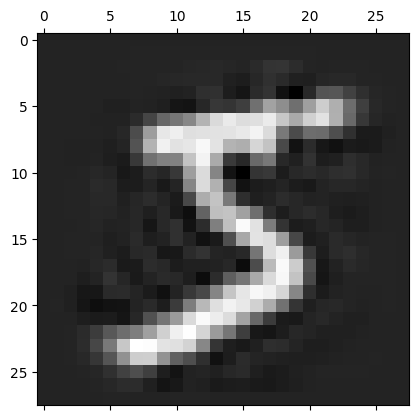

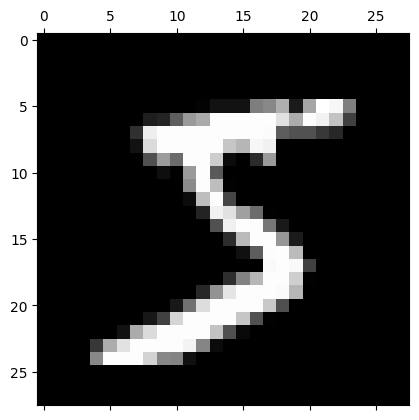

In [26]:
plt.gray()
plt.matshow(X_recovered[0].reshape(28,28))
plt.matshow(X_tr[0].reshape(28,28))

# Randomized PCA
Complexity is O(m * d<sup>2</sup>) + O(d<sup>3</sup>) rather than O(m * n<sup>2</sup>) + O(n<sup>3</sup>)s
<br>So it's dramatically faster when d << n

Set `svd_solver` to "randomized"
<br>By default, it's "auto", so it uses randomized PCA if max(m, n) > 500 and n_components is an int smaller than 80% of min(m, n)
<br>To force it to use full SVD, set it to "full"

In [27]:
rnd_pca = PCA(n_components=154, svd_solver="randomized", random_state=42)
X_reduced = rnd_pca.fit_transform(X_tr)

<Figure size 640x480 with 0 Axes>

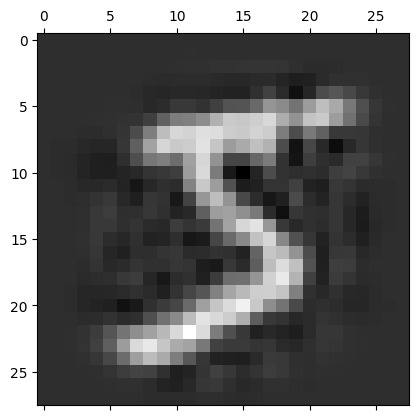

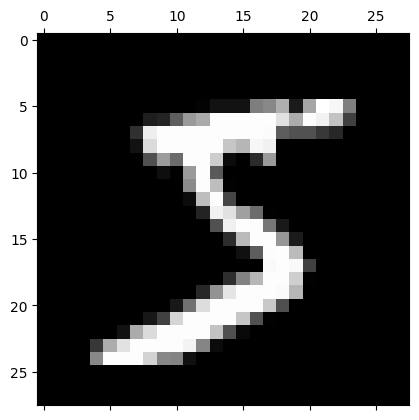

In [29]:
plt.gray()
plt.matshow((pca.inverse_transform(X_reduced))[0].reshape(28,28))
plt.matshow(X_tr[0].reshape(28,28))

# Incremental PCA
Doesn't require training set to fit in memory.
<br>Useful for large training sets and for applying PCA online (on the fly, as new instances arrive)

Need to call `partial_fit` instead of `fit`

In [30]:
from sklearn.decomposition import IncrementalPCA

n_batches = 100
inc_pca = IncrementalPCA(n_components=154)
for X_b in np.array_split(X_tr, n_batches):
    inc_pca.partial_fit(X_b)
X_reduced = inc_pca.transform(X_tr)

Can also use numpy's `memmap`.
<br>Allows to manipulate a large array stored in a binary file on disk as if it were in memory.
<br>It only loads the data when it needs it.

In [31]:
filename = "my_mnist.mmap"
X_mmap = np.memmap(filename, dtype='float32', mode='write', shape=X_tr.shape)

# could be a loop which saves the data chunk by chunk
X_mmap[:] = X_tr

X_mmap.flush()

In [32]:
# only raw binary data is saved
# so we need to specify the dtype and shape
# Omitting shape gives a 1D array
X_mmap = np.memmap(filename, dtype='float32', mode='readonly').reshape(-1,784)
batch_size = X_mmap.shape[0] // n_batches
inc_pca =IncrementalPCA(n_components=154, batch_size=batch_size)

# can call fit cuz IncrementalPCA uses only a small part of array at a time
# so memory usage remains under control
inc_pca.fit(X_mmap)

IncrementalPCA(batch_size=600, n_components=154)

# Random Projection
Use if dealing with tens of thousands of features (e.g. images).
<br>In high-dim datasets, PCA and even randomized PCA can be slow

<br>It projects data to a lower-dim space using a random linear projection.
<br>Turns out such random projection is very likely to preserve distances fairly well.
  - is a famous Lemma
  - 2 similar instances will remain similar, 2 different instances will remain different

For optimal number of dims, there's an equation which determines the minimum number of dims to preserve in order to ensure (with high proba) that distances won't change by more than a given tolerance.
<br>E.g., m=5k, n=20k, tolerance/eps = 10%, then d >= 4 log(m) / (1/2 * eps<sup>2</sup> - 1/3 * eps<sup>3</sup>), which is 7.3k
<br>Equation only relies on m and eps

In [33]:
from sklearn.random_projection import johnson_lindenstrauss_min_dim

m, eps = 5_000, 0.1
d = johnson_lindenstrauss_min_dim(m, eps=eps)
d

np.int64(7300)

For projection, generate a random matrix P of shape (d, n), where each item is sampled from Gaussian dst with mean 0 and variance 1/d

In [34]:
n = 20_000

np.random.seed(42)
P = np.random.randn(d, n) / np.sqrt(d)  # sqrt(d) is std dev, d is variance of this matrix
X = np.random.randn(m, n)

X_reduced = X @ P.T

This algo only needs the data's shape, not the data itself to create matrix P

Can also directly use `GaussianRandomProjection`

In [35]:
from sklearn.random_projection import GaussianRandomProjection

gaussian_rnd_proj = GaussianRandomProjection(eps=eps, random_state=42)
X_reduced = gaussian_rnd_proj.fit_transform(X)

Another option is to use SparseRandomProjection
<br>Main difference is that the matrix P is sparse
<br>This uses 25MB memory instead of around 1.2GB for the above example
<br>It's also faster to generate matrix P and to reduce dim
<br>If input is sparse, it keeps it sparse (unless `dense_output`=True)
<br>Also has same distance-preserving property

So, this option is preferrable.

Ratio of nonzero items is called <b>density</b>
<br>By default, r = 1/n
<br>For n = 20k, only 1 in around 141 cells is nonzero
<br>Each cell has proba "r" of being nonzero
<br>Each nonzero value is either -v or +v, where v = 1/(d*r)

### Inverse Transformation
For inverse transformation, need to compute pseudo-inverse of the components matrix

Calculating pseudo-inverse takes O(dn<sup>2</sup>) if d < n, otherwise O(nd<sup>2</sup>)
<br>So this can take a very long time

In [38]:
components_pinv = np.linalg.pinv(gaussian_rnd_proj.components_)
X_recovered = X_reduced @ components_pinv.T

### Random Projection for Locality Sensitive Hashing
Random Projection is not only used for dim reduction.
<br>A 2017 paper shows the brain of a fruit fly does something analogous to random proojection to map dense low-dim olfactory inputs to sparse high-dim binary outputs
  - for each odor, only a small fraction of output neurons is activated
  - but similar odors activate many of the same neurons
<br>This is similar to <b>Locality Sensitive Hashing</b> (LSH), used typically in search engines to group similar documents

# Locally Linear Embedding
Nonlinear dim reduction (NLDR) technique.
<br>Doesn't rely on projections.

Works by measuring how each instance relates to its nearest neighbors, then looks for a low-dim representation of trainign set where these local relationships are best preserved.
<br>Makes it good at unrolling twisted manifolds, esp. when there isn't much noise

In [39]:
from sklearn.datasets import make_swiss_roll
from sklearn.manifold import LocallyLinearEmbedding

# "t" contains position of each instance along the rolled axis
# can be used as a target for a nonlinear regression task
X_swiss, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)
lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10, random_state=42)

X_unrolled = lle.fit_transform(X_swiss)

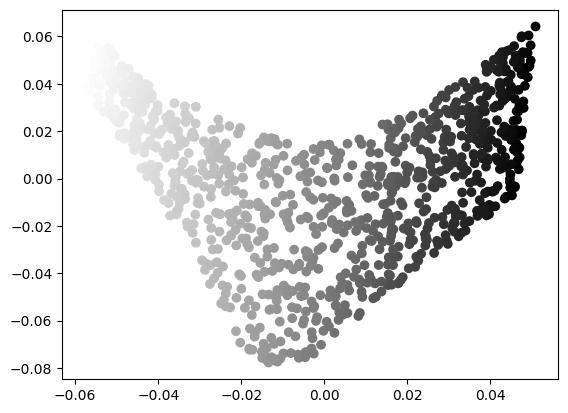

In [52]:
# Local distances are preserved
# But distances on larger scale aren't
# The unrolled Swiss roll should be a rectangle
plt.scatter(X_unrolled[:, 0], X_unrolled[:, 1], c=((t - t.min()) / (t.max() - t.min())))
plt.show()

### Working

#### First Step
- For each instance x(i), identify its k-nearest neighbors (k=10 in above)
- Reconstruct x(i) as f(neighbors)
  - finds w_ij such that squared distance b/w x(i) and sum(w_ij * x(j)) is smallest
    - assuming w_ij = 0 if x(j) isn't a nearest neighbor
- So this step solves the constrained optimization problem:
<br>W = argmin<sub>w</sub>(sum<sub>i=1 to m</sub>(x(i) - sum<sub>j=1 to m</sub>(w_ij * x(j))<sup>2</sup>))
<br>subject to w_ij = 0 if x(j) is not k-nn of x(i)
<br>sum<sub>j=1 to m</sub>(w_ij) = 1 for i=1, ..., m
  - this constraint normalizes the weights
- Now, W encodes local linear relationships b/w instances

#### Second Step
- Map instances into d-dim (d < n) while preserving local relationships
- if z(i) is image of x(i) in d-dim, then we want squared distance b/w z(i) and sum<sub>j=1 to m</sub>(w_ij * z(j)) to be smallest
  - This looks similar, but instead of keeping instances fixed and finding optimal weights, we keep weights fixed and find optimal position of instances' images
- So this solves:
<br>Z = argmin<sub>z</sub>(sum<sub>i=1 to m</sub>(z(i) - sum<sub>j=1 to m</sub>(w_ij * z(j))<sup>2<sup>))

Sklearn's implementation has complexity:
- O(m * log(m) * n * log(k)) for finding k-nn
- O(m * n * k<sup>3</sup>) for optimizing weights
- O(d * m<sup>2</sup>) for constructing low-dim representations
<br>The m<sup>2</sup> makes it scale poorly.

# Other Dim Reduction Techniques
- sklearn.manifold.MDS
  - Multidimensional Scaling (MDS)
  - Reduces dims while preserving distances b/w instances
  - Random Projection does this for high-dim data, but doesn't work well on low-dim
- sklearn.manifold.Isomap
  - Creates a graph by connecting instances with their nearest neighbors
  - Then reduces dim while trying to preserve geodesic distances b/w instacnes
    - Geodesic distance is the number of nodes on the shortest path b/w 2 nodes
- sklearn.manifold.TSNE
  - t-distributed stochastic neighbor embedding (t-SNE)
  - Reduces dim while trying to keep similar instances close and dissimilar apart
  - Mostly for viz, in particular to visualize clusters of instances in high-dim
- sklearn.discriminant_analysis.LinearDiscriminantAnalysis
  - LDA is a linear clf algo
  - Learns most discriminative axes b/w classes
  - These axes define a hyperplane to project onto
  - Benefit is that projection keeps classes as far apart as possible
  - So it's a good technique to reduce dim before running some other clf algo